In [11]:
# initialization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
import re
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import time

nltk.download('punkt')
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/fionchai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fionchai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

In [12]:
%%script false --no-raise-error # comment this if you dont have the dev_set

# import dataset
train_set = pd.read_csv('train.csv')

test_set = pd.read_csv('test.csv')

# from train_set sample development set
dev_set = train_set.sample(n=500, replace=False)

# remove dev set from train set
train_set = train_set.drop(dev_set.index)

# check
print(train_set.shape, dev_set.shape, test_set.shape)

# save to dataframe
dev_set.to_csv("dev_set.csv", index=False)
train_set.to_csv("train_set_modified.csv", index=False)

In [13]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

## Preprocess data


In [14]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

In [15]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [16]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [17]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [18]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [19]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)

  x = torch.tensor(np.array(padded_sentences))

  return x

X_dev = preprocess_x(dev_set)
X_train = preprocess_x(train_set)
print(X_train.shape)
# print(torch.isnan(x_dev).any().item())


torch.Size([4952, 18, 300])


### Prepare data for training

In [20]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)

In [21]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

# mini-batch strategy
batch_size = 32

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)



/var/folders/s6/9xhy3ssd0snfcfh5ys7848y40000gn/T/ipykernel_40363/1526020532.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


##  LSTM model

In [22]:
HIDDEN_SIZE = 128
OUTPUT_SIZE = 5
NUM_LAYERS = 1


class simple_lstm(nn.Module):
    def __init__(
                    self,
                    input_size = 300,
                    hidden_size= HIDDEN_SIZE,
                    output_size= OUTPUT_SIZE,
                    num_layers= NUM_LAYERS,
                   # dropout_rate= 0.2,
                    bidirectional= True,
                ):

        super().__init__()
        # Model body
        self.lstm = nn.LSTM(input_size= input_size, hidden_size= hidden_size, bidirectional= bidirectional, num_layers= num_layers, batch_first= True)

        # Model head
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * hidden_size, output_size),
           # nn.Dropout(dropout_rate),
            nn.Softmax(dim= 2)
        )

    def __call__(self, input):
        out, _ = self.lstm(input) # out dim = 32 x max_length x 256

        #  apply max pooling along the sequence dimension
        pooled_output = F.max_pool2d(out, kernel_size=(out.size(1), 1), stride=(out.size(1), 1)) # pooled output dim = 32 x 1 x 256, out.size(1) to match max_length of dataset

        return self.head(pooled_output) # expected dim = 32 x 1 x 5

## Find optimal batch size

In [23]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
model = simple_lstm(input_dim, 128, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [25]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  model = simple_lstm(input_dim, 128, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
      
  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time 
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.31590
Epoch: 0, dev set loss: 1.17708
Accuracy: 73.00%
Epoch: 1, training set loss: 1.16703
Epoch: 1, dev set loss: 1.16446
Accuracy: 73.60%
Epoch: 2, training set loss: 1.11649
Epoch: 2, dev set loss: 1.14652
Accuracy: 75.00%
Epoch: 3, training set loss: 1.08694
Epoch: 3, dev set loss: 1.12431
Accuracy: 79.00%
Epoch: 4, training set loss: 1.06055
Epoch: 4, dev set loss: 1.10345
Accuracy: 79.00%
Epoch: 5, training set loss: 1.04464
Epoch: 5, dev set loss: 1.11224
Accuracy: 78.60%
Epoch: 6, training set loss: 1.03309
Epoch: 6, dev set loss: 1.10617
Accuracy: 79.80%
Epoch: 7, training set loss: 1.02262
Epoch: 7, dev set loss: 1.11544
Accuracy: 79.00%
Epoch: 8, training set loss: 1.01279
Epoch: 8, dev set loss: 1.10223
Accuracy: 80.20%
Epoch: 9, training set loss: 1.00598
Epoch: 9, dev set loss: 1.09491
Accuracy: 81.20%
Epoch: 10, training set loss: 0.99826
Epoch: 10, dev set loss: 1.10196
Accuracy: 79.80%
Epoch: 11, training set loss: 0.99461
Epoch: 11, dev

In [26]:
accuracy_list_batch_size

{2: 0.7886999999999998,
 4: 0.7875000000000001,
 8: 0.7778,
 16: 0.7608000000000001,
 24: 0.7534000000000001,
 32: 0.7569000000000001,
 64: 0.7460000000000001,
 128: 0.7188000000000001,
 256: 0.6744000000000001,
 512: 0.6217999999999999}

Text(0.5, 1.0, 'Accuracy against Batch size')

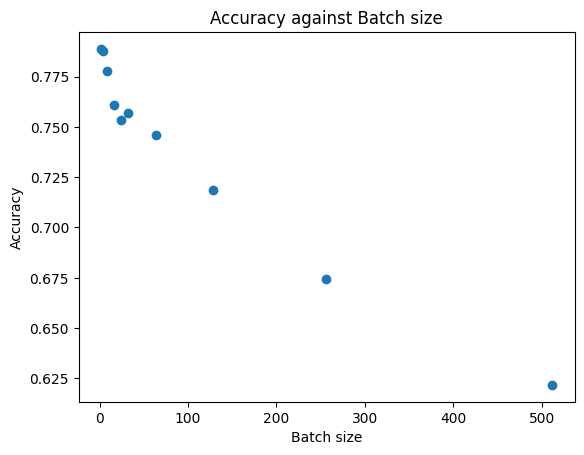

In [27]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

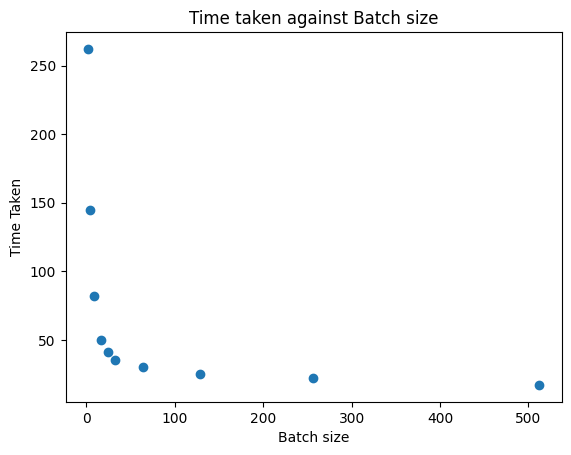

In [28]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")

Text(0.5, 1.0, 'Loss against Batch size')

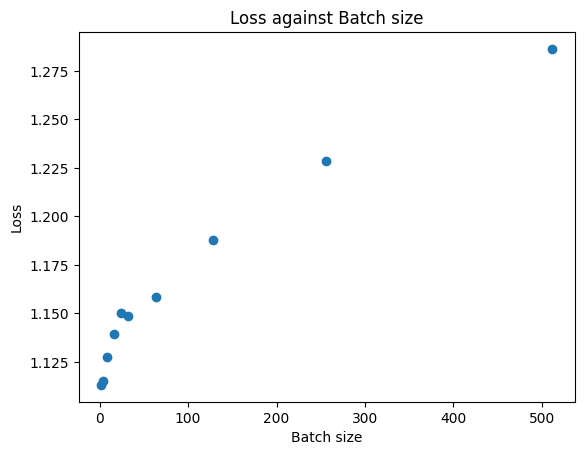

In [29]:
# Plot dev loss against batch size
plt.scatter(loss_batch_size.keys(), loss_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Loss against Batch size")

Based on the result shown above, batch size of 24 is chosen for it's accuracy and time taken.

## Find optimal number of hidden layers

In [30]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_size = 24
num_layers = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [32]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_num_layers = {}
time_taken_num_layers = {}
loss_num_layers = {}

for layer in num_layers:
  model = simple_lstm(input_dim, 128, 5, layer)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_num_layers[layer] =  end_time - start_time 
  accuracy_list_num_layers[layer] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_num_layers[layer] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.42384
Epoch: 0, dev set loss: 1.28508
Accuracy: 66.40%
Epoch: 1, training set loss: 1.22892
Epoch: 1, dev set loss: 1.19864
Accuracy: 71.40%
Epoch: 2, training set loss: 1.17314
Epoch: 2, dev set loss: 1.18103
Accuracy: 73.40%
Epoch: 3, training set loss: 1.13403
Epoch: 3, dev set loss: 1.16362
Accuracy: 74.40%
Epoch: 4, training set loss: 1.11737
Epoch: 4, dev set loss: 1.16317
Accuracy: 73.40%
Epoch: 5, training set loss: 1.10521
Epoch: 5, dev set loss: 1.14912
Accuracy: 75.40%
Epoch: 6, training set loss: 1.09332
Epoch: 6, dev set loss: 1.12614
Accuracy: 77.80%
Epoch: 7, training set loss: 1.07711
Epoch: 7, dev set loss: 1.12303
Accuracy: 78.60%
Epoch: 8, training set loss: 1.06460
Epoch: 8, dev set loss: 1.12518
Accuracy: 77.60%
Epoch: 9, training set loss: 1.05500
Epoch: 9, dev set loss: 1.12711
Accuracy: 77.60%
Epoch: 10, training set loss: 1.04711
Epoch: 10, dev set loss: 1.12333
Accuracy: 77.80%
Epoch: 11, training set loss: 1.03701
Epoch: 11, dev

In [33]:
accuracy_list_num_layers

{1: 0.767,
 2: 0.7493000000000001,
 3: 0.7074,
 4: 0.5114,
 5: 0.387,
 6: 0.38870000000000005}

Text(0.5, 1.0, 'Accuracy against Number of Layers')

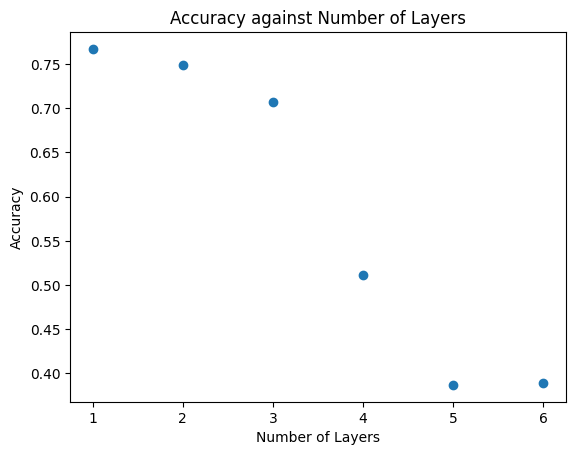

In [34]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_num_layers.keys(), accuracy_list_num_layers.values())
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Layers")

Text(0.5, 1.0, 'Time taken against Number of Layers')

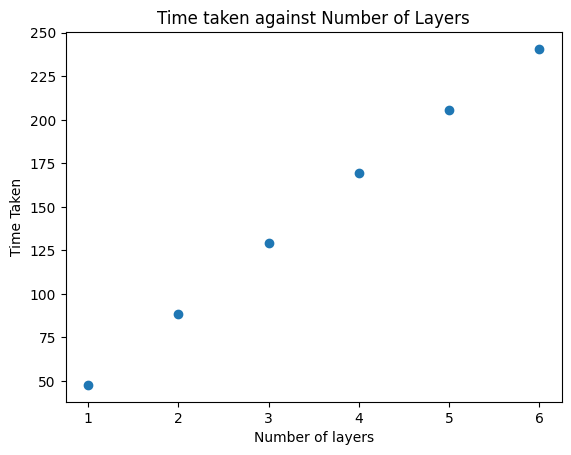

In [35]:
# Plot dev time against batch size
plt.scatter(time_taken_num_layers.keys(), time_taken_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Layers")

Text(0.5, 1.0, 'Loss against Number of Layers')

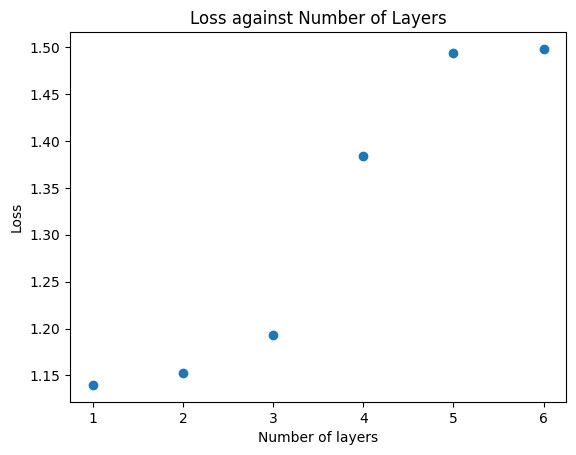

In [36]:
# Plot dev loss against batch size
plt.scatter(loss_num_layers.keys(), loss_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Loss")
plt.title("Loss against Number of Layers")

As seen in the result, having 1 hidden layer results in the highest accuracy and shortest time taken. Hence, 1 hidden layer is used.

## Find optimal number of hidden neurons

In [37]:
input_dim = embed_shape
hidden_dims = [64, 138, 256, 512]
output_dim = 5
layer_dim = 300
batch_size = 24
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [39]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_hidden_dims = {}
time_taken_hidden_dims = {}
loss_hidden_dims = {}

for hidden_dim in hidden_dims:
  model = simple_lstm(input_dim, hidden_dim, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_hidden_dims[hidden_dim] =  end_time - start_time 
  accuracy_list_hidden_dims[hidden_dim] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_hidden_dims[hidden_dim] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.45485
Epoch: 0, dev set loss: 1.31467
Accuracy: 61.40%
Epoch: 1, training set loss: 1.26774
Epoch: 1, dev set loss: 1.22578
Accuracy: 68.40%
Epoch: 2, training set loss: 1.19838
Epoch: 2, dev set loss: 1.18894
Accuracy: 72.20%
Epoch: 3, training set loss: 1.15580
Epoch: 3, dev set loss: 1.16535
Accuracy: 73.80%
Epoch: 4, training set loss: 1.13115
Epoch: 4, dev set loss: 1.15793
Accuracy: 75.00%
Epoch: 5, training set loss: 1.11199
Epoch: 5, dev set loss: 1.14372
Accuracy: 77.00%
Epoch: 6, training set loss: 1.09629
Epoch: 6, dev set loss: 1.14963
Accuracy: 76.00%
Epoch: 7, training set loss: 1.07982
Epoch: 7, dev set loss: 1.13548
Accuracy: 77.20%
Epoch: 8, training set loss: 1.06660
Epoch: 8, dev set loss: 1.12637
Accuracy: 77.40%
Epoch: 9, training set loss: 1.05912
Epoch: 9, dev set loss: 1.12318
Accuracy: 77.80%
Epoch: 10, training set loss: 1.05137
Epoch: 10, dev set loss: 1.12917
Accuracy: 77.40%
Epoch: 11, training set loss: 1.04021
Epoch: 11, dev

In [40]:
accuracy_list_hidden_dims

{64: 0.7566, 138: 0.7628999999999999, 256: 0.7533000000000001, 512: 0.7472}

Text(0.5, 1.0, 'Accuracy against Number of Hidden Neurons')

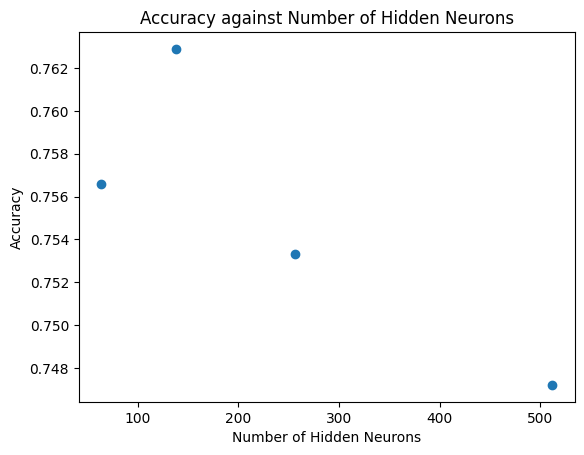

In [41]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_hidden_dims.keys(), accuracy_list_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Hidden Neurons")

Text(0.5, 1.0, 'Time taken against Number of Hidden Neurons')

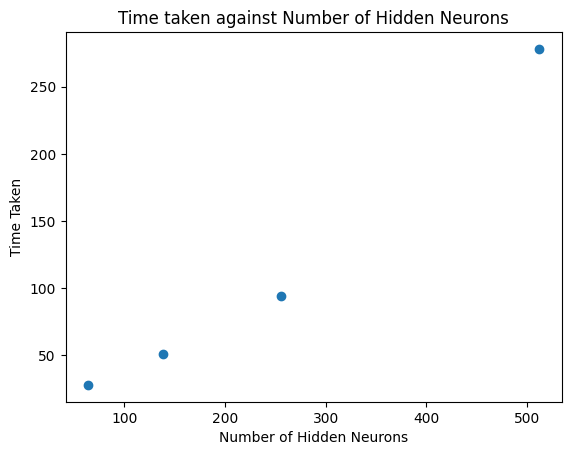

In [42]:
# Plot dev time against batch size
plt.scatter(time_taken_hidden_dims.keys(), time_taken_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Hidden Neurons")

Text(0.5, 1.0, 'Loss against Number of Hidden Neurons')

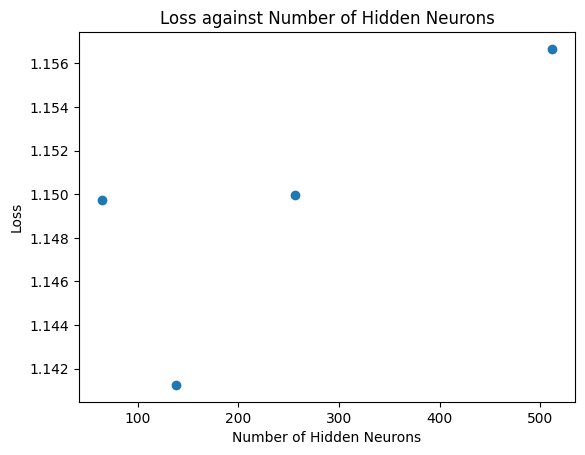

In [43]:
# Plot dev loss against batch size
plt.scatter(loss_hidden_dims.keys(), loss_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Loss")
plt.title("Loss against Number of Hidden Neurons")

As model with 256 neurons results in the highest accuracy, 256 neurons are used.

## Final model training

In [44]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
model = simple_lstm(input_dim, 128, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [45]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [46]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  model = simple_lstm(input_dim, 128, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
      
  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time 
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.34366
Epoch: 0, dev set loss: 1.19903
Accuracy: 70.40%
Epoch: 1, training set loss: 1.17385
Epoch: 1, dev set loss: 1.15967
Accuracy: 74.00%
Epoch: 2, training set loss: 1.13539
Epoch: 2, dev set loss: 1.13887
Accuracy: 76.20%
Epoch: 3, training set loss: 1.10689
Epoch: 3, dev set loss: 1.13310
Accuracy: 76.60%
Epoch: 4, training set loss: 1.08298
Epoch: 4, dev set loss: 1.14035
Accuracy: 75.40%
Epoch: 5, training set loss: 1.06041
Epoch: 5, dev set loss: 1.10496
Accuracy: 80.20%
Epoch: 6, training set loss: 1.03946
Epoch: 6, dev set loss: 1.10162
Accuracy: 80.00%
Epoch: 7, training set loss: 1.02700
Epoch: 7, dev set loss: 1.09995
Accuracy: 80.80%
Epoch: 8, training set loss: 1.01808
Epoch: 8, dev set loss: 1.11473
Accuracy: 78.60%
Epoch: 9, training set loss: 1.00707
Epoch: 9, dev set loss: 1.10086
Accuracy: 79.80%
Epoch: 10, training set loss: 0.99749
Epoch: 10, dev set loss: 1.08689
Accuracy: 81.80%
Epoch: 11, training set loss: 0.99132
Epoch: 11, dev

In [47]:
accuracy_list_batch_size

{2: 0.7936000000000001,
 4: 0.7871,
 8: 0.7757000000000001,
 16: 0.7749999999999999,
 24: 0.7532,
 32: 0.756,
 64: 0.7384000000000001,
 128: 0.7164999999999999,
 256: 0.6872,
 512: 0.6317999999999999}

Text(0.5, 1.0, 'Accuracy against Batch size')

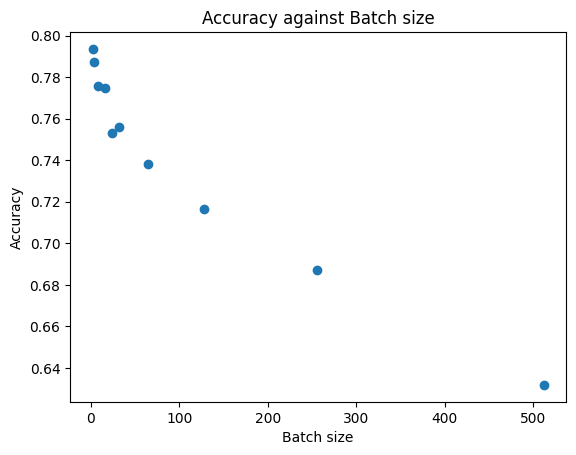

In [48]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

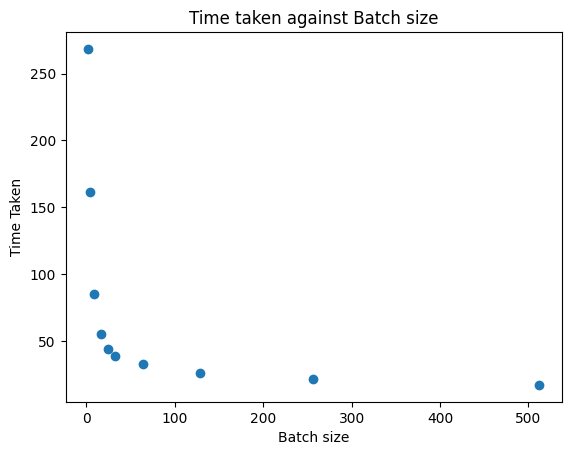

In [49]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")

Text(0.5, 1.0, 'Loss against Batch size')

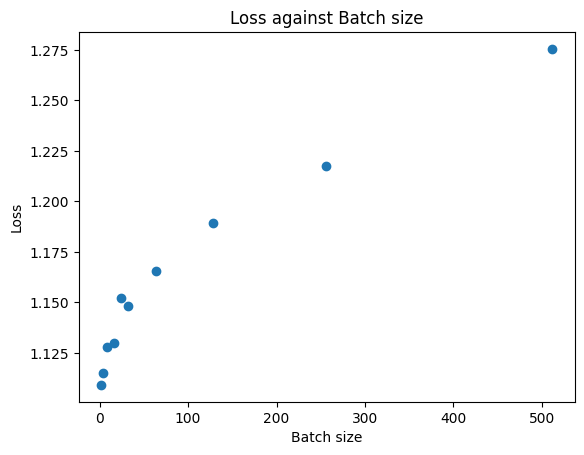

In [50]:
# Plot dev loss against batch size
plt.scatter(loss_batch_size.keys(), loss_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Loss against Batch size")

Based on the result shown above, batch size of 24 is chosen for it's accuracy and time taken.

## Find optimal number of hidden layers

In [51]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_size = 24
num_layers = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [52]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [53]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_num_layers = {}
time_taken_num_layers = {}
loss_num_layers = {}

for layer in num_layers:
  model = simple_lstm(input_dim, 128, 5, layer)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_num_layers[layer] =  end_time - start_time 
  accuracy_list_num_layers[layer] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_num_layers[layer] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.44827
Epoch: 0, dev set loss: 1.30614
Accuracy: 62.80%
Epoch: 1, training set loss: 1.25227
Epoch: 1, dev set loss: 1.21053
Accuracy: 70.00%
Epoch: 2, training set loss: 1.18302
Epoch: 2, dev set loss: 1.18535
Accuracy: 72.00%
Epoch: 3, training set loss: 1.15081
Epoch: 3, dev set loss: 1.15458
Accuracy: 75.40%
Epoch: 4, training set loss: 1.12926
Epoch: 4, dev set loss: 1.16290
Accuracy: 74.40%
Epoch: 5, training set loss: 1.11105
Epoch: 5, dev set loss: 1.14277
Accuracy: 75.60%
Epoch: 6, training set loss: 1.09551
Epoch: 6, dev set loss: 1.13891
Accuracy: 76.60%
Epoch: 7, training set loss: 1.07997
Epoch: 7, dev set loss: 1.12778
Accuracy: 78.00%
Epoch: 8, training set loss: 1.06927
Epoch: 8, dev set loss: 1.13943
Accuracy: 75.80%
Epoch: 9, training set loss: 1.05296
Epoch: 9, dev set loss: 1.12597
Accuracy: 78.00%
Epoch: 10, training set loss: 1.04279
Epoch: 10, dev set loss: 1.12990
Accuracy: 77.80%
Epoch: 11, training set loss: 1.03749
Epoch: 11, dev

In [54]:
accuracy_list_num_layers

{1: 0.7529000000000001,
 2: 0.7288999999999998,
 3: 0.6971999999999999,
 4: 0.6602999999999999,
 5: 0.3910999999999999,
 6: 0.35919999999999996}

Text(0.5, 1.0, 'Accuracy against Number of Layers')

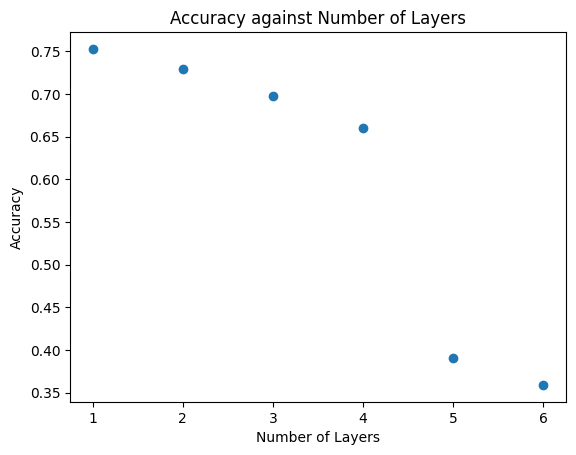

In [55]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_num_layers.keys(), accuracy_list_num_layers.values())
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Layers")

Text(0.5, 1.0, 'Time taken against Number of Layers')

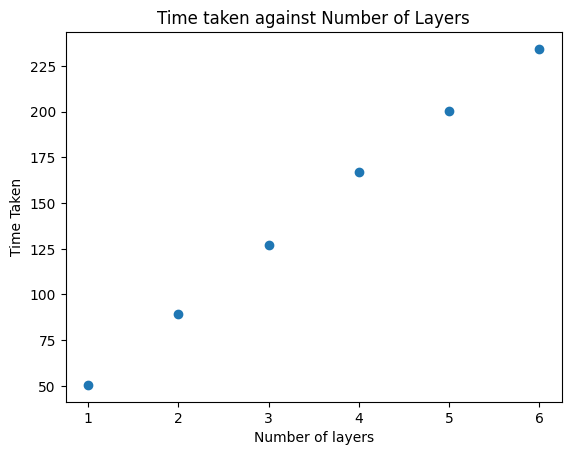

In [56]:
# Plot dev time against batch size
plt.scatter(time_taken_num_layers.keys(), time_taken_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Layers")

Text(0.5, 1.0, 'Loss against Number of Layers')

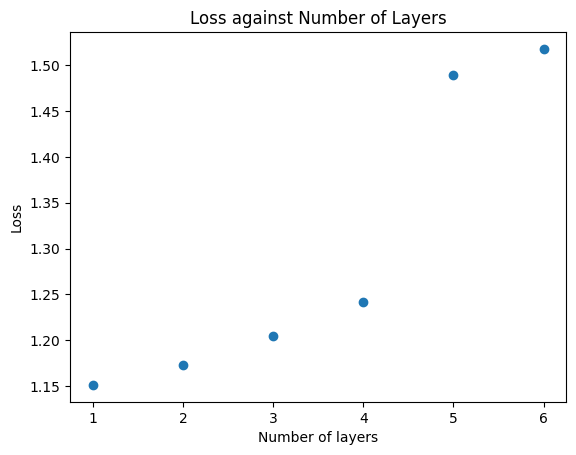

In [57]:
# Plot dev loss against batch size
plt.scatter(loss_num_layers.keys(), loss_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Loss")
plt.title("Loss against Number of Layers")

As seen in the result, having 1 hidden layer results in the highest accuracy and shortest time taken. Hence, 1 hidden layer is used.

## Find optimal number of hidden neurons

In [58]:
input_dim = embed_shape
hidden_dims = 256
output_dim = 5
layer_dim = 300
batch_size = 24
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [59]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [60]:
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
dev_accuracy_list = []

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0

  for x_batch, y_batch in train_loader:
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  def calculate_accuracy(y_true, y_pred):
      y_true = y_true.detach().cpu().numpy()
      y_pred = y_pred.detach().cpu().numpy()
      return accuracy_score(y_true, y_pred)

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        break


Epoch: 0, training set loss: 1.53205
Epoch: 0, dev set loss: 1.52022
Accuracy: 32.40%
Epoch: 1, training set loss: 1.53406
Epoch: 1, dev set loss: 1.52824
Accuracy: 33.60%
Epoch: 2, training set loss: 1.52988
Epoch: 2, dev set loss: 1.51858
Accuracy: 33.60%
Epoch: 3, training set loss: 1.52693
Epoch: 3, dev set loss: 1.51611
Accuracy: 33.60%
Epoch: 4, training set loss: 1.52535
Epoch: 4, dev set loss: 1.51446
Accuracy: 33.60%
Epoch: 5, training set loss: 1.52487
Epoch: 5, dev set loss: 1.51476
Accuracy: 33.60%
Epoch: 6, training set loss: 1.52542
Epoch: 6, dev set loss: 1.51441
Accuracy: 33.60%
Early stopping after 6 epochs.


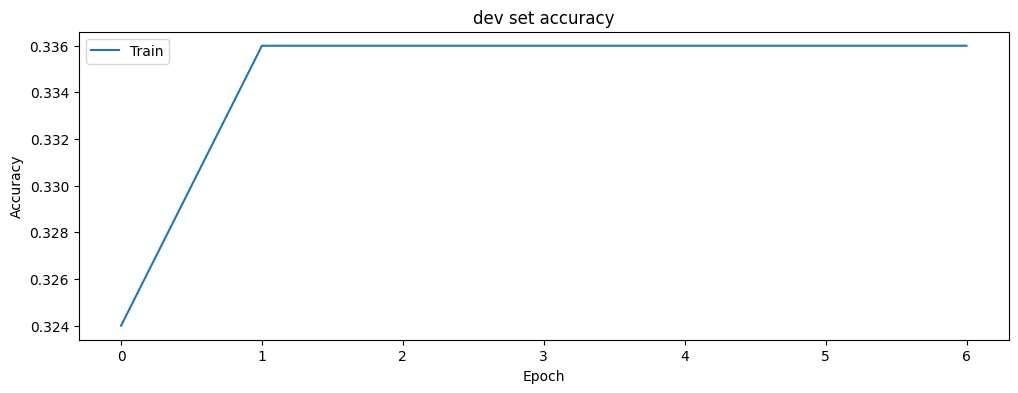

In [61]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('dev set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()